# PyGIMLi - Complex valued ERT

Using the ERT solver implemented provided by [PyGIMLi](https://www.pygimli.org/), 
we use different `cofi` solvers to solve the corresponding inverse problem.

<!-- Please leave the cell below as it is -->

<!--<badge>--><a href="https://colab.research.google.com/github/inlab-geo/cofi-examples/blob/main/notebooks/pygimli_dcip/pygimli_dcip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--</badge>-->

<!-- Again, please don't touch the markdown cell above. We'll generate badge 
     automatically from the above cell. -->

<!-- This cell describes things related to environment setup, so please add more text 
     if something special (not listed below) is needed to run this notebook -->

> If you are running this notebook locally, make sure you've followed [steps here](https://github.com/inlab-geo/cofi-examples#run-the-examples-with-cofi-locally)
to set up the environment. (This [environment.yml](https://github.com/inlab-geo/cofi-examples/blob/main/environment.yml) file
specifies a list of packages required to run the notebooks)

## 0. Import modules

In [1]:
# -------------------------------------------------------- #
#                                                          #
#     Uncomment below to set up environment on "colab"     #
#                                                          #
# -------------------------------------------------------- #

# !pip install -U cofi

# !MINICONDA_INSTALLER_SCRIPT=Miniconda3-4.5.4-Linux-x86_64.sh
# !MINICONDA_PREFIX=/usr/local
# !wget https://repo.continuum.io/miniconda/$MINICONDA_INSTALLER_SCRIPT
# !chmod +x $MINICONDA_INSTALLER_SCRIPT
# !./$MINICONDA_INSTALLER_SCRIPT -b -f -p $MINICONDA_PREFIX
# !conda install -c gimli pygimli -y

# import sys
# _ = (sys.path.append("/usr/local/lib/python3.7/site-packages"))

We will need the following packages:

- `numpy` for matrices and matrix-related functions
- `matplotlib` for plotting
- `pygimli` for forward modelling of the problem
- `cofi` for accessing different inference solvers

Additionally, we wrap some `pygimli` code in file `pygimli_dcip_lib.py` and import it
here for conciseness.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from cofi import BaseProblem, InversionOptions, Inversion

from pygimli_dcip_lib import *

np.random.seed(42)

## 1. Define the problem

We first define the true model, the survey and map it on a computational mesh designed for the survey and true anomaly.

Text(0.5, 1.0, 'Chargeability')

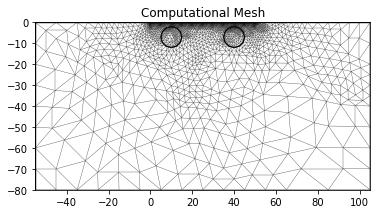

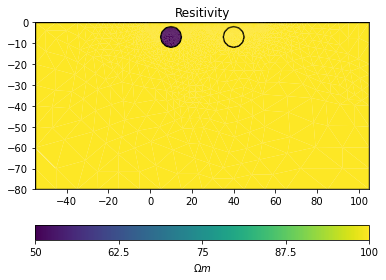

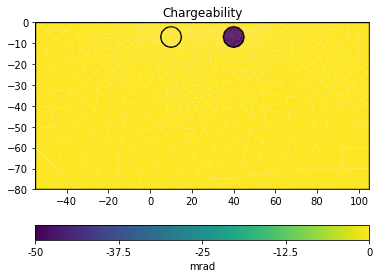

In [3]:
# PyGIMLi - define measuring scheme, geometry, forward mesh and true model
scheme = scheme_fwd()
geometry = geometry_true()
fmesh = mesh_fwd(scheme, geometry)
rhomap = markers_to_resistivity()
model_true = model_vec(rhomap, fmesh)

# plot the compuational mesh and the true model
ax=pygimli.show(fmesh)
ax[0].set_title("Computational Mesh")
ax=pygimli.show(fmesh, data=np.abs(model_true), label=r"$\Omega m$")
ax[0].set_title("Resitivity")
ax=pygimli.show(fmesh, data=np.arctan2(np.imag(model_true), np.real(model_true)) * 1000,label=r"mrad",)
ax[0].set_title("Chargeability") 

Generate the synthetic data as a container with all the necessary information for plotting.

14/07/22 - 12:46:41 - pyGIMLi - INFO - Complex resistivity values found.


14/07/22 - 12:46:41 - pyGIMLi - INFO - Calculate geometric factors.


ModellingBase::setMesh() copying new mesh ... Found datafile: 51 electrodes
Found: 51 free-electrodes
rMin = 0.5, rMax = 100
NGauLeg + NGauLag for inverse Fouriertransformation: 13 + 4
Found non-Neumann domain
0.037 s
FOP updating mesh dependencies ... 0 s
Obtaining geometric factors (analytical)


Calculating response for model: min = (50,0) max = (100,0)
Allocating memory for primary potential...... 0.01

No primary potential for secondary field calculation. Calculating analytically...
Assembling system matrix ... Factorizing (Umfpack) system matrix ... Assembling system matrix ... Factorizing (Umfpack) system matrix ... Assembling system matrix ... Factorizing (Umfpack) system matrix ... Assembling system matrix ... Factorizing (Umfpack) system matrix ... Assembling system matrix ... Factorizing (Umfpack) system matrix ... Assembling system matrix ... Factorizing (Umfpack) system matrix ... Assembling system matrix ... Factorizing (Umfpack) system matrix ... Assembling system matrix ... Factorizing (Umfpack) system matrix ... Assembling system matrix ... Factorizing (Umfpack) system matrix ... Assembling system matrix ... Factorizing (Umfpack) system matrix ... Assembling system matrix ... Factorizing (Umfpack) system matrix ... Assembling system matrix ... Factorizing (Umfpac

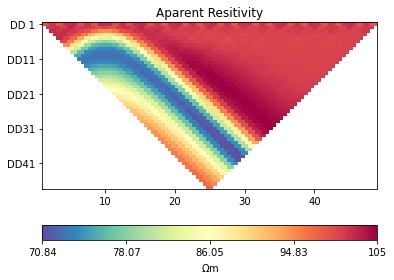

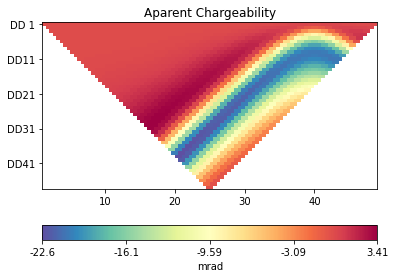

In [4]:
# PyGIMLi - generate data
survey = ert.simulate(fmesh, res=rhomap, scheme=scheme)

y_obs = survey['rhoa'].array() * np.exp(1j * survey['phia'].array())

ax=ert.showERTData(survey, vals=np.real(y_obs),label=r"$\Omega$m")
ax[0].set_title("Aparent Resitivity")
ax=ert.showERTData(survey, vals=np.arctan2(np.imag(y_obs), np.real(y_obs)) * 1000, label=r"mrad")
ax[0].set_title("Aparent Chargeability");

The inversion can use a different mesh and the mesh to be used should know nothing about the mesh that was designed based on the true model. We wrap two kinds of mesh as examples in the library code `pygimli_dcip_lib.py`, namely triangular and rectangular mesh.

Use `imesh_tri = mesh_inv_triangular(scheme)` to initialise a triangular mesh, with the following optional arguments and corresponding default values:

- `start=[-15, 0]`
- `end=[65, -30]`

Use `imesh_rect = mesh_inv_rectangular()` to initislise a rectangular mesh, with the following optional arguments and corresponding default values:

- `x_start=-15`
- `x_stop=60`
- `x_num=11`
- `y_start=-30`
- `y_stop=0`
- `y_num=5`

Here we first demonstrate how to use a *triangular mesh*. Note that this makes the inversion problem under-determined.

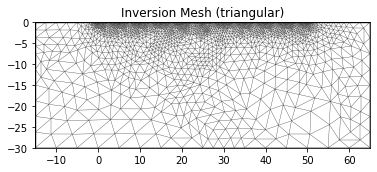

In [5]:
# PyGIMLi - quick demo of triangular mesh
imesh_tri = mesh_inv_triangular(scheme)

ax=pygimli.show(imesh_tri)
ax[0].set_title("Inversion Mesh (triangular)");

Check [here](https://github.com/inlab-geo/cofi-examples/tree/main/notebooks/pygimli_dcip)
for inversion examples using triangular mesh.

For the purpose of this notebook, we use a *rectangular mesh* for a simple demonstration.

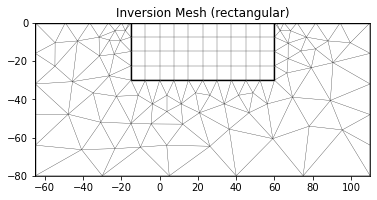

In [6]:
# PyGIMLi - create mesh for inversion
imesh = mesh_inv_rectangular()
ax = pygimli.show(imesh)
ax[0].set_title("Inversion Mesh (rectangular)");

With the inversion mesh created, we now define a starting model, forward operator and 
weighting matrix for regularisation using PyGIMLi.

In [7]:
# PyGIMLi - define the starting model on the inversion mesh
model_0 = starting_model(imesh)

# PyGIMLi - set up a forward operator with the inversion mesh
forward_operator = forward_oprt(scheme, imesh)

# PyGIMLi - extract the regularisation weighting matrix
Wm = weighting_matrix(forward_operator, imesh)

14/07/22 - 12:46:48 - Core - INFO - More than 50 regions, so we assume single regions only.


14/07/22 - 12:46:48 - Core - INFO - Applying *:* interregion constraints.


CoFI and other inference packages require a set of functions that provide the misfit, the jacobian the residual within the case of scipy standardised interfaces. All these functions are defined in the library file `pygimli_ert_lib.py`, so open this file if you'd like to find out the details. These functions are:

- `get_response`
- `get_jacobian`
- `get_residuals`
- `get_misfit`
- `get_regularisation`
- `get_gradient`
- `get_hessian`

With all the above forward operations set up with PyGIMLi, we now define the problem in `cofi`
by setting the problem information for a `BaseProblem` object.

In [8]:
# hyperparameters
lamda = 1

# cofi problem definition
ert_problem = BaseProblem()
ert_problem.name = "Complex valued ERT defined through PyGIMLi"
ert_problem.set_forward(get_response, args=[forward_operator])
ert_problem.set_jacobian(get_jacobian, args=[forward_operator])
ert_problem.set_residual(get_residuals, args=[y_obs, forward_operator])
ert_problem.set_data_misfit(get_misfit, args=[y_obs, forward_operator, True])
ert_problem.set_regularisation(get_regularisation, lamda=lamda, args=[Wm, True])
ert_problem.set_gradient(get_gradient, args=[y_obs, forward_operator, lamda, Wm])
ert_problem.set_hessian(get_hessian, args=[y_obs, forward_operator, lamda, Wm])
ert_problem.set_initial_model(model_0)

Review what information is included in the `BaseProblem` object:

In [9]:
ert_problem.summary()

Summary for inversion problem: Complex valued ERT defined through PyGIMLi
Model shape: (193,)
-------------------------------------------------------------------------
List of functions/properties set by you:
['gradient', 'hessian', 'residual', 'jacobian', 'data_misfit', 'regularisation', 'forward', 'initial_model', 'model_shape']
-------------------------------------------------------------------------
List of functions/properties created based on what you have provided:
['objective', 'hessian_times_vector', 'jacobian_times_vector']
-------------------------------------------------------------------------
List of functions/properties not set by you:
['objective', 'log_posterior', 'log_posterior_with_blobs', 'log_likelihood', 'log_prior', 'hessian_times_vector', 'jacobian_times_vector', 'data', 'data_covariance', 'data_covariance_inv', 'walkers_starting_pos', 'blobs_dtype', 'bounds', 'constraints']


## 2. Define the inversion options

As what [pygimli_ert.ipynb](https://github.com/inlab-geo/cofi-examples/blob/main/notebooks/pygimli_ert/pygimli_ert.ipynb) example does, we use a Newton's iterative approach written by ourselves, so you'll have a closer look at what's happening in the loop.

First of all, define our own solver.

In [10]:
from cofi.solvers import BaseSolver

class MyNewtonSolver(BaseSolver):
    def __init__(self, inv_problem, inv_options):
        __params = inv_options.get_params()
        self._niter = __params["niter"]
        self._step = __params["step"]
        self._verbose = __params["verbose"]
        self._model_0 = inv_problem.initial_model
        self._gradient = inv_problem.gradient
        self._hessian = inv_problem.hessian
        self._misfit = inv_problem.data_misfit if inv_problem.data_misfit_defined else None
        self._reg = inv_problem.regularisation if inv_problem.regularisation_defined else None
        self._obj = inv_problem.objective if inv_problem.objective_defined else None
        
    def __call__(self):
        current_model = np.array(self._model_0)
        for i in range(self._niter):
            term1 = self._hessian(current_model)
            term2 = - self._gradient(current_model)
            model_update = np.linalg.solve(term1, term2)
            current_model = np.array(current_model + self._step * model_update)
            if self._verbose:
                print("-" * 80)
                print(f"Iteration {i+1}")
                if self._misfit: self._misfit(current_model)
                if self._reg: self._reg(current_model)
                # if self._obj: print("objective func:", self._obj(current_model))
        return {"model": current_model, "success": True}

Now, make use of this custom solver to define inversion options.

In [11]:
inv_options_own_solver = InversionOptions()
inv_options_own_solver.set_tool(MyNewtonSolver)
inv_options_own_solver.set_params(niter=20, step=1, verbose=True)

Review what's been defined for the inversion we are about to run:

In [12]:
inv_options_own_solver.summary()

Summary for inversion options
Solving method: None set
Use `suggest_solving_methods()` to check available solving methods.
-----------------------------
Backend tool: `<class '__main__.MyNewtonSolver'>` - 
References: []
Use `suggest_tools()` to check available backend tools.
-----------------------------
Solver-specific parameters: 
niter = 20
step = 1
verbose = True
Use `suggest_solver_params()` to check required/optional solver-specific parameters.


## 3. Start an inversion

In [13]:
inv_own_solver = Inversion(ert_problem, inv_options_own_solver)
inv_own_solver_res = inv_own_solver.run()
inv_own_solver_res.summary()

14/07/22 - 12:46:48 - pyGIMLi - INFO - Creating forward mesh from region infos.


14/07/22 - 12:46:48 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


*** check /home/florian/miniconda3/conda-bld/pgcore_1645022399690/work/gimli/core/src/bert/dcfemmodelling.cpp:1424	


*** check /home/florian/miniconda3/conda-bld/pgcore_1645022399690/work/gimli/core/src/bert/dcfemmodelling.cpp:1424	


--------------------------------------------------------------------------------
Iteration 1
data misfit: 9143420.599776449
raw regularisation: (3364.994801569056-313.7704854313309j)


*** check /home/florian/miniconda3/conda-bld/pgcore_1645022399690/work/gimli/core/src/bert/dcfemmodelling.cpp:1424	


*** check /home/florian/miniconda3/conda-bld/pgcore_1645022399690/work/gimli/core/src/bert/dcfemmodelling.cpp:1424	


--------------------------------------------------------------------------------
Iteration 2
data misfit: 9057412.759415831
raw regularisation: (8665.852165605365-1155.8735125447556j)


*** check /home/florian/miniconda3/conda-bld/pgcore_1645022399690/work/gimli/core/src/bert/dcfemmodelling.cpp:1424	


*** check /home/florian/miniconda3/conda-bld/pgcore_1645022399690/work/gimli/core/src/bert/dcfemmodelling.cpp:1424	


--------------------------------------------------------------------------------
Iteration 3
data misfit: 8997453.292139592
raw regularisation: (15163.218260452684-2397.296776088183j)


*** check /home/florian/miniconda3/conda-bld/pgcore_1645022399690/work/gimli/core/src/bert/dcfemmodelling.cpp:1424	


*** check /home/florian/miniconda3/conda-bld/pgcore_1645022399690/work/gimli/core/src/bert/dcfemmodelling.cpp:1424	


--------------------------------------------------------------------------------
Iteration 4
data misfit: 8951413.091206882
raw regularisation: (22512.495036119406-3962.0260358322084j)
*** check /home/florian/miniconda3/conda-bld/pgcore_1645022399690/work/gimli/core/src/bert/dcfemmodelling.cpp:1424	


*** check /home/florian/miniconda3/conda-bld/pgcore_1645022399690/work/gimli/core/src/bert/dcfemmodelling.cpp:1424	


--------------------------------------------------------------------------------
Iteration 5
data misfit: 8914050.06835279
raw regularisation: (30540.418630056804-5796.0185555349535j)


*** check /home/florian/miniconda3/conda-bld/pgcore_1645022399690/work/gimli/core/src/bert/dcfemmodelling.cpp:1424	


*** check /home/florian/miniconda3/conda-bld/pgcore_1645022399690/work/gimli/core/src/bert/dcfemmodelling.cpp:1424	


--------------------------------------------------------------------------------
Iteration 6
data misfit: 8882617.228523739
raw regularisation: (39109.86838203798-7855.653807028882j)


*** check /home/florian/miniconda3/conda-bld/pgcore_1645022399690/work/gimli/core/src/bert/dcfemmodelling.cpp:1424	


*** check /home/florian/miniconda3/conda-bld/pgcore_1645022399690/work/gimli/core/src/bert/dcfemmodelling.cpp:1424	


--------------------------------------------------------------------------------
Iteration 7
data misfit: 8855494.350741332
raw regularisation: (48114.7914057945-10102.067250185411j)


*** check /home/florian/miniconda3/conda-bld/pgcore_1645022399690/work/gimli/core/src/bert/dcfemmodelling.cpp:1424	


*** check /home/florian/miniconda3/conda-bld/pgcore_1645022399690/work/gimli/core/src/bert/dcfemmodelling.cpp:1424	


--------------------------------------------------------------------------------
Iteration 8
data misfit: 8831645.424460297
raw regularisation: (57473.036088258916-12499.78766616628j)


*** check /home/florian/miniconda3/conda-bld/pgcore_1645022399690/work/gimli/core/src/bert/dcfemmodelling.cpp:1424	


*** check /home/florian/miniconda3/conda-bld/pgcore_1645022399690/work/gimli/core/src/bert/dcfemmodelling.cpp:1424	


--------------------------------------------------------------------------------
Iteration 9
data misfit: 8810367.796153462
raw regularisation: (67119.79965616067-15016.643746360112j)


*** check /home/florian/miniconda3/conda-bld/pgcore_1645022399690/work/gimli/core/src/bert/dcfemmodelling.cpp:1424	


*** check /home/florian/miniconda3/conda-bld/pgcore_1645022399690/work/gimli/core/src/bert/dcfemmodelling.cpp:1424	


--------------------------------------------------------------------------------
Iteration 10


data misfit: 8791162.974120112
raw regularisation: (77002.92301781465-17623.90826355248j)


*** check /home/florian/miniconda3/conda-bld/pgcore_1645022399690/work/gimli/core/src/bert/dcfemmodelling.cpp:1424	


*** check /home/florian/miniconda3/conda-bld/pgcore_1645022399690/work/gimli/core/src/bert/dcfemmodelling.cpp:1424	


--------------------------------------------------------------------------------
Iteration 11
data misfit: 8773664.514681825
raw regularisation: (87079.7624938163-20296.364021587597j)


*** check /home/florian/miniconda3/conda-bld/pgcore_1645022399690/work/gimli/core/src/bert/dcfemmodelling.cpp:1424	


*** check /home/florian/miniconda3/conda-bld/pgcore_1645022399690/work/gimli/core/src/bert/dcfemmodelling.cpp:1424	
--------------------------------------------------------------------------------
Iteration 12


data misfit: 8757595.171654314
raw regularisation: (97315.11218370355-23012.23284692084j)


*** check /home/florian/miniconda3/conda-bld/pgcore_1645022399690/work/gimli/core/src/bert/dcfemmodelling.cpp:1424	


*** check /home/florian/miniconda3/conda-bld/pgcore_1645022399690/work/gimli/core/src/bert/dcfemmodelling.cpp:1424	


--------------------------------------------------------------------------------
Iteration 13
data misfit: 8742740.125093753
raw regularisation: (107679.77527823354-25752.990362608427j)


*** check /home/florian/miniconda3/conda-bld/pgcore_1645022399690/work/gimli/core/src/bert/dcfemmodelling.cpp:1424	


*** check /home/florian/miniconda3/conda-bld/pgcore_1645022399690/work/gimli/core/src/bert/dcfemmodelling.cpp:1424	


--------------------------------------------------------------------------------
Iteration 14


data misfit: 8728929.552771691
raw regularisation: (118149.53699376633-28503.12379506844j)


*** check /home/florian/miniconda3/conda-bld/pgcore_1645022399690/work/gimli/core/src/bert/dcfemmodelling.cpp:1424	


*** check /home/florian/miniconda3/conda-bld/pgcore_1645022399690/work/gimli/core/src/bert/dcfemmodelling.cpp:1424	


--------------------------------------------------------------------------------
Iteration 15
data misfit: 8716026.88801024
raw regularisation: (128704.34384918716-31249.817152508404j)


*** check /home/florian/miniconda3/conda-bld/pgcore_1645022399690/work/gimli/core/src/bert/dcfemmodelling.cpp:1424	


*** check /home/florian/miniconda3/conda-bld/pgcore_1645022399690/work/gimli/core/src/bert/dcfemmodelling.cpp:1424	


--------------------------------------------------------------------------------
Iteration 16
data misfit: 8703920.670861075
raw regularisation: (139327.76576852123-33982.52198042295j)


*** check /home/florian/miniconda3/conda-bld/pgcore_1645022399690/work/gimli/core/src/bert/dcfemmodelling.cpp:1424	


*** check /home/florian/miniconda3/conda-bld/pgcore_1645022399690/work/gimli/core/src/bert/dcfemmodelling.cpp:1424	


--------------------------------------------------------------------------------
Iteration 17
data misfit: 8692518.754039612
raw regularisation: (150006.4165017519-36692.97067289142j)


*** check /home/florian/miniconda3/conda-bld/pgcore_1645022399690/work/gimli/core/src/bert/dcfemmodelling.cpp:1424	


*** check /home/florian/miniconda3/conda-bld/pgcore_1645022399690/work/gimli/core/src/bert/dcfemmodelling.cpp:1424	


--------------------------------------------------------------------------------
Iteration 18
data misfit: 8681744.084170043
raw regularisation: (160729.48375806113-39374.60861810919j)


*** check /home/florian/miniconda3/conda-bld/pgcore_1645022399690/work/gimli/core/src/bert/dcfemmodelling.cpp:1424	


*** check /home/florian/miniconda3/conda-bld/pgcore_1645022399690/work/gimli/core/src/bert/dcfemmodelling.cpp:1424	


--------------------------------------------------------------------------------
Iteration 19
data misfit: 8671531.57949182
raw regularisation: (171488.43990541232-42022.4362359344j)


*** check /home/florian/miniconda3/conda-bld/pgcore_1645022399690/work/gimli/core/src/bert/dcfemmodelling.cpp:1424	


*** check /home/florian/miniconda3/conda-bld/pgcore_1645022399690/work/gimli/core/src/bert/dcfemmodelling.cpp:1424	


--------------------------------------------------------------------------------
Iteration 20
data misfit: 8661825.772956215
raw regularisation: (182276.67943781242-44632.77040764566j)
Summary for inversion result
SUCCESS
----------------------------
model: [1705.22098265-28.47254067j 1880.97018335-52.38605584j
 1702.23085924-28.950934j   1850.20727149-43.93381468j
 1691.37968753-27.88846691j 1688.6039015 -25.75917595j
 1691.46452978-30.06292543j 1701.78399508-30.81321579j
 1700.92701061-25.26063805j 1863.0479898 -46.83547375j
 1681.47786561-24.22985995j 1800.56711929-35.10358606j
 1680.63763857-23.19453926j 1704.44267376-20.05195067j
 1700.13742364-30.1811959j  1722.99673337-24.24419751j
 1889.08414655-54.7542996j  1723.00845811-22.86191331j
 1672.2724836 -21.45095398j 1887.15319746-52.22224288j
 1737.22633154-28.19874169j 1694.89718923-28.02621532j
 1887.56766822-54.24068483j 1695.60508922-31.2745045j
 1703.96878442-31.10829813j 1700.97749577-31.21261047j
 1696.3303586 -27.27206914j 

## 4. Plotting

Text(0.5, 1.0, 'Inferred model')

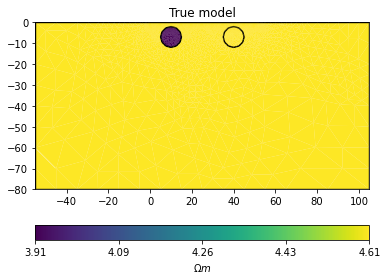

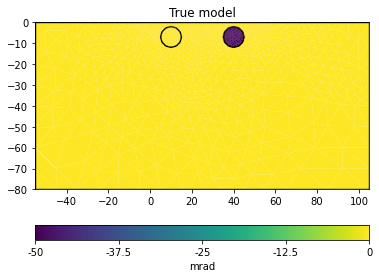

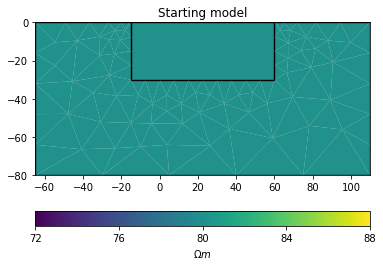

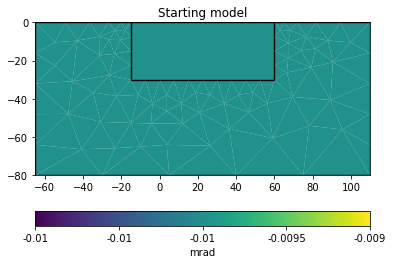

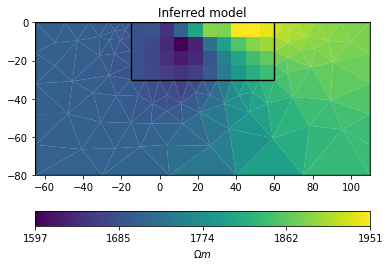

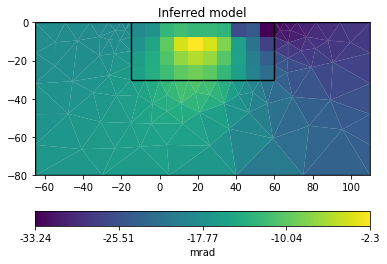

In [14]:

ax=pygimli.show(
    fmesh,
    data=np.log(np.abs(model_true)),
    label=r"$\Omega m$"
)
ax[0].set_title("True model")

ax=pygimli.show(
    fmesh,
    data=np.arctan2(np.imag(model_true), np.real(model_true)) * 1000,
    label=r"mrad"
)
ax[0].set_title("True model")

ax=pygimli.show(
    imesh,
    data=(model_0.real),
    label=r"$\Omega m$"
)
ax[0].set_title("Starting model")

ax=pygimli.show(
    imesh,
    data=np.arctan2(np.imag(model_0), np.real(model_0)) * 1000,
    label=r"mrad"
)
ax[0].set_title("Starting model")

ax=pygimli.show(
    imesh,
    data=(inv_own_solver_res.model.real),
    label=r"$\Omega m$"
)
ax[0].set_title("Inferred model")

ax=pygimli.show(
    imesh,
    data=np.arctan2(np.imag(inv_own_solver_res.model), np.real(inv_own_solver_res.model)) * 1000,
    label=r"mrad"
)
ax[0].set_title("Inferred model")


---
## Watermark

<!-- Feel free to add more modules in the watermark_list below, if more packages are used -->
<!-- Otherwise please leave the below code cell unchanged -->

In [15]:
watermark_list = ["cofi", "numpy", "scipy", "pygimli", "matplotlib"]
for pkg in watermark_list:
    pkg_var = __import__(pkg)
    print(pkg, getattr(pkg_var, "__version__"))

cofi 0.1.2.dev8
numpy 1.21.6
scipy 1.8.1
pygimli 1.2.6
matplotlib 3.5.2
